In [ ]:
import json
import os
import shutil
import sys

import cv2
from tqdm import tqdm

# global variables
PATH_JSON = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_v0.3.json'


def main():
    try:
        # command line inputs
        path_dataset = r'C:\Users\anany\Downloads\WLASL-dataset-sample\videos'
        glosses = 20
        if not 1 <= glosses <= 2000:
            raise ValueError('\nInsert an integer: 1~2000')

        # set the name of dir that will contain the spilt
        path_k_glosses_dir = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_' + str(glosses) + '/'

        print('[log] > START DATASET PROCESSING ...\n')
        dataset_processing(glosses, path_k_glosses_dir, path_dataset)
        show_info(path_k_glosses_dir)
        print('\n[log] > DONE!')

    except ValueError:
        print('Insert an integer: 1~2000')


def dataset_processing(glosses, path_k_glosses_dir, path_dataset):
    # read the json as a list of dictionaries
    wlasl_json = read_json(PATH_JSON)

    # split the videos in train, val and test
    splitted_videos = splitting_train_val_test(wlasl_json, glosses)

    # create dirs in which we'll store the videos
    make_target_dirs(wlasl_json, glosses, path_k_glosses_dir)

    # copy the videos in their own dir
    save_in_dirs(path_dataset, path_k_glosses_dir, splitted_videos)


def read_json(file_path):
    with open(file_path) as f:
        wlasl_json = json.load(f)
    return wlasl_json


def splitting_train_val_test(json_file, glosses):
    print('[log] > Splitting videos in train, val and test ...')
    # save in a dictionary the 'video_id' - ['target_dit', ] pair
    videos_dict = {}
    for k, gloss in tqdm(enumerate(json_file)):  # iterate through each gloss
        if k < glosses:
            videos = gloss['instances']  # get all videos as array
            for video in videos:
                video_id = video['video_id']
                target_dir = video['split']  # get destination dir
                gloss_name = gloss['gloss']
                videos_dict[video_id] = (target_dir, gloss_name)
        else:
            break

    return videos_dict


def save_in_dirs(path_dataset, path_k_glosses_dir, videos):
    print('\n[log] > Copying videos to their respective directories ...')
    # Iterate through each video and copy it to the target directory
    for video_id, data in tqdm(videos.items()):
        source_url = os.path.join(path_dataset, f'{video_id}.mp4')
        destination_dir = os.path.join(path_k_glosses_dir, data[0], data[1])
        
        # Ensure the destination directory exists
        os.makedirs(destination_dir, exist_ok=True)
        
        try:
            # Attempt to copy the video file
            shutil.copy(source_url, destination_dir)
        except FileNotFoundError:
            # Log and skip if the video file is not found
            print(f'[warn] Skipping missing video: {video_id}')



def make_target_dirs(json_file, glosses, path_k_glosses_dir):
    # delete the existing target dir, if it exists
    if os.path.isdir('./' + path_k_glosses_dir):
        shutil.rmtree(path_k_glosses_dir)

    # create the target dir
    os.mkdir(path_k_glosses_dir)
    # create the train, val and test dirs
    os.mkdir(path_k_glosses_dir + 'train')
    os.mkdir(path_k_glosses_dir + 'val')
    os.mkdir(path_k_glosses_dir + 'test')

    print('\n[log] > Creating dirs ...')
    for k, gloss in tqdm(enumerate(json_file)):  # iterate through each gloss
        if k < glosses:
            # create as many folders as there are glosses
            os.mkdir(path_k_glosses_dir + 'train/' + gloss['gloss'])
            os.mkdir(path_k_glosses_dir + 'val/' + gloss['gloss'])
            os.mkdir(path_k_glosses_dir + 'test/' + gloss['gloss'])
        else:
            break


def show_info(path_k_glosses_dir):
    # print the numbers of videos
    print_entries(path_k_glosses_dir)

    # print the videos info
    print_videos_info(path_k_glosses_dir)


def print_entries(path_root):
    path_train = path_root + 'train/'
    path_val = path_root + 'val/'
    path_test = path_root + 'test/'

    n_tot = sum([len(files) for _, _, files in os.walk(path_root)])
    n_train = sum([len(files) for _, _, files in os.walk(path_train)])
    n_val = sum([len(files) for _, _, files in os.walk(path_val)])
    n_test = sum([len(files) for _, _, files in os.walk(path_test)])

    print('\n[log] > Dataset summary:')
    print(f'Total videos: {n_tot}')
    print(f'Videos in train: {n_train} - {(n_train / n_tot * 100):,.0f}%')
    print(f'Videos in val:   {n_val} - {(n_val / n_tot * 100):,.0f}%')
    print(f'Videos in test:  {n_test} - {(n_test / n_tot * 100):,.0f}%')


def print_videos_info(path_root):
    videos = get_videos_path(path_root)
    info = get_videos_info(videos)

    print('\n[log] > Dataset info:')
    print(
        f'The video {info[0][0]} has the MIN length: {info[0][1]} - '
        f'Total frames: {info[0][2]}'
    )
    print(
        f'The video {info[-1][0]} has the MAX length: {info[-1][1]} - '
        f'Total frames: {info[-1][2]}'
    )


def get_videos_path(path_root):
    # get videos path
    paths = []
    for root, dirs, files in os.walk(os.path.relpath(path_root)):
        for file in files:
            paths.append(os.path.join(root, file))

    return paths


def get_videos_info(videos):
    print('\n[log] > Retrieving videos metadata ...')
    lengths = [get_meta_data(vid_path) for vid_path in tqdm(videos)]

    return sorted(lengths, key=lambda x: x[1])  # sorted by duration


def get_meta_data(file_path):
    video_cap = cv2.VideoCapture(file_path)
    fps = video_cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    video_cap.release()

    file_name = os.path.basename(os.path.normpath(file_path))
    return file_name, duration, frame_count


if __name__ == '__main__':
    main()

In [2]:
import itertools
import os

import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class VideoFrameGenerator(keras.utils.Sequence):
    """
    The VideoFrameGenerator extracts n frames from a video.

    You can choose between two sampling mode:
    - Mode 1: extracts n frames from the entire video.
    - Mode 2: extracts n frames from the entire video, but first performs a
    pre-sampling to eliminate the initial and final sequences in witch no
    movements appear.
    """

    def __init__(self, list_IDs, labels, batch_size=32, dim=(32, 32),
                 n_channels=3, n_sequence=10, shuffle=True, type_gen='train'):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_sequence = n_sequence  # number of frames to extract
        self.shuffle = shuffle
        self.type_gen = type_gen
        self.sampl_mode = '2'
        self.aug_gen = ImageDataGenerator()
        print(f'Videos: {len(self.list_IDs)}, batches per epoch: '
              f'{int(np.floor(len(self.list_IDs) / self.batch_size))}')
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[
                  index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def frame_sampling(self, len_frames):
        """
        Sample the video with the chosen policy.

        :param len_frames: video length (in frames)
        :return: the indexes of the sampled frames.
        """
        # create a list of frames
        frames = list(range(len_frames))

        # sampling choice
        if self.sampl_mode == '1':
            # create chunks
            chunks = list(self.get_chunks(frames, self.n_sequence))
            sampling = self.sampling_mode_1(chunks)
        elif self.sampl_mode == '2':
            sampling = self.sampling_mode_2(frames, self.n_sequence)
        else:
            raise ValueError

        return sampling

    def sampling_mode_1(self, chunks):
        """
        Select 10 frames from the entire sequence.

        :param chunks: blocks from which to select frames.
        :return: the indexes of the 10 frames sampled.
        """
        sampling = []
        for i, chunk in enumerate(chunks):
            if i == 0 or i == 1:
                sampling.append(chunk[-1])  # get the last frame
            elif i == (len(chunks) - 1) or i == (len(chunks) - 2):
                sampling.append(chunk[0])  # get the first frame
            else:
                sampling.append(chunk[len(chunk) // 2])  # get the central frame

        return sampling

    def sampling_mode_2(self, frames, n_sequence):
        """
        Do a pre-sampling by creating 12 chunks. Then apply the first sampling
        mode (sampling_mode_1 function).

        :param frames: list of frames.
        :param n_sequence: number of frames to sample.
        :return: the indexes of the 10 frames sampled.
        """
        # create 12 chunks
        chunks = list(self.get_chunks(frames, 12))

        # remove the first and the last chunk
        sub_chunks = chunks[1:-1]

        # get a the new list of frames
        sub_frame_list = list(itertools.chain.from_iterable(sub_chunks))

        # create n_sequence(10) chunks
        new_chunks = list(self.get_chunks(sub_frame_list, n_sequence))

        sampling = self.sampling_mode_1(new_chunks)

        return sampling

    def get_chunks(self, l, n):
        # divide indexes list in n chunks
        k, m = divmod(len(l), n)
        return (l[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in
                range(n))

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, self.n_sequence, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(list_IDs_temp):  # ID: path to file
            path_file = ID
            cap = cv2.VideoCapture(path_file)
            if not cap.isOpened():
                print(f"Warning: Unable to open video file: {path_file}")
                continue  # Skip this video if it cannot be opened
        
            # get number of frames
            length_file = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if length_file == 0:
                print(f"Warning: Video file is empty or has zero frames: {path_file}")
                cap.release()
                continue  # Skip this video
        
            index_sampling = self.frame_sampling(length_file)  # sampling indexes

            for j, n_pic in enumerate(index_sampling):
                cap.set(cv2.CAP_PROP_POS_FRAMES, n_pic)  # jump to that index
                ret, frame = cap.read()
                if not ret or frame is None:
                    print(f"Warning: Empty or invalid frame at index {n_pic} in video: {path_file}")
                    continue  # Skip this frame
            
                try:
                    new_image = cv2.resize(frame, self.dim)
                    X[i, j, :, :, :] = new_image
                except Exception as e:
                    print(f"Error resizing frame at index {n_pic} in video: {path_file}: {e}")
                    continue

            if self.type_gen == 'train':
                X[i,] = self.sampling_augmentation(X[i,]) / 255.0
            else:
                X[i,] = X[i,] / 255.0

            Y[i] = self.labels[ID]
            cap.release()

            # Debugging: Uncomment to save sampled frames for inspection
            # self.save_frame_sampling(X, i, ID, len(index_sampling))

        return X, Y


    def sampling_augmentation(self, sequence):
        """
        - `'theta'`: Float. Rotation angle in degrees.
        - `'tx'`: Float. Shift in the x direction. - vertical shift (height)
        - `'ty'`: Float. Shift in the y direction. - horizontal shift (width)
        - `'shear'`: Float. Shear angle in degrees.
        - `'zx'`: Float. Zoom in the x direction. - vertical zoom
        - `'zy'`: Float. Zoom in the y direction. - horizontal zoom
        - `'flip_horizontal'`: Boolean. Horizontal flip.
        - `'flip_vertical'`: Boolean. Vertical flip.
        - `'channel_shift_intensity'`: Float. Channel shift intensity.
        - `'brightness'`: Float. Brightness shift intensity.
        """
        transformations = ['theta', 'tx', 'ty', 'zx', 'zy', 'flip_horizontal',
                           'brightness']

        # random choice of number of transformations
        random_transforms = np.random.randint(2, 4)  # min 2 - max 3
        # random choice of transformations
        transforms_idxs = np.random.choice(len(transformations),
                                           random_transforms, replace=False)

        transfor_parameters = {}
        for idx in transforms_idxs:
            if transformations[idx] == 'theta':
                transfor_parameters['theta'] = np.random.randint(-5, 5)

            elif transformations[idx] == 'tx':
                transfor_parameters['tx'] = np.random.randint(-10, 10)

            elif transformations[idx] == 'ty':
                transfor_parameters['ty'] = np.random.randint(-15, 15)

            elif transformations[idx] == 'zx':
                transfor_parameters['zx'] = np.random.uniform(0.6, 1.05)

            elif transformations[idx] == 'zy':
                transfor_parameters['zy'] = np.random.uniform(0.6, 1.05)

            elif transformations[idx] == 'flip_horizontal':
                transfor_parameters['flip_horizontal'] = True

            elif transformations[idx] == 'brightness':
                transfor_parameters['brightness'] = np.random.uniform(0.4, 0.6)

        len_seq = sequence.shape[0]
        for i in range(len_seq):
            sequence[i] = self.aug_gen.apply_transform(sequence[i],
                                                       transfor_parameters)

        return sequence

    def save_frame_sampling(self, samp_imgs, i, img_path, n_frames):
        # concatenate all frames
        train_frame = ()
        for n_f in range(n_frames):
            train_frame = (*train_frame, samp_imgs[i, n_f,] * 255.0)

        # get the train of frame in one image
        full_img = np.concatenate(train_frame, axis=1)

        # info
        img_name = (os.path.split(img_path)[1])[:-4]
        img_label = os.path.split(os.path.split(img_path)[0])[1]

        # save the image
        if not os.path.isdir('./sampling_test/'):
            os.mkdir('./sampling_test/')

        name_file = self.type_gen + '_' + img_label + '_' + img_name
        cv2.imwrite('./sampling_test/' + name_file + '.jpg', full_img)

print("Done")

Done


In [3]:
"""
The proposed models are valid for the WLASL20custom, WLASL100, WLASL300,
WLASL1000 and WLASL2000 datasets.
"""
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import TimeDistributed, GRU, BatchNormalization
from tensorflow.keras.models import Sequential


def create_model_wlasl20c(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=64, activation='relu'),
        Dropout(0.65),
        Dense(units=32, activation='relu'),
        Dropout(0.65),
        Dense(units=output, activation='softmax')
    ])

    return model


def create_model_wlasl100(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=200, activation='relu'),
        Dropout(0.66),
        Dense(units=150, activation='relu'),
        Dropout(0.66),
        Dense(units=output, activation='softmax')
    ])

    return model


def create_model_wlasl300(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=400, activation='relu'),
        Dropout(0.6),
        Dense(units=350, activation='relu'),
        Dropout(0.6),
        Dense(units=output, activation='softmax')
    ])

    return model


def create_model_wlasl1000(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=512, activation='relu'),
        Dropout(0.7),
        Dense(units=output, activation='softmax')
    ])

    return model


def create_model_wlasl2000(frames, width, height, channels, output):
    """
    Create the keras model.

    :param frames: frame number of the sequence.
    :param width: width of the image.
    :param height: height of the image.
    :param channels: 3 for RGB, 1 for B/W images.
    :param output: number of neurons for classification.
    :return: the keras model.
    """
    model = Sequential([
        # ConvNet
        TimeDistributed(
            MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=[height, width, channels]),
            input_shape=[frames, height, width, channels]
        ),
        TimeDistributed(GlobalAveragePooling2D()),

        # GRUs
        GRU(256, return_sequences=True),
        BatchNormalization(),
        GRU(256),

        # Feedforward
        Dense(units=1000, activation='relu'),
        Dropout(0.75),
        Dense(units=output, activation='softmax')
    ])

    return model

print("Done")

Done


In [4]:
import glob
import os


def labels_to_number(base_path):
    """
    Map labels (folder names) to numeric values.
    """
    if not os.path.exists(base_path):
        print(f"Warning: Base path '{base_path}' does not exist. Skipping...")
        return {}
    
    labels = {}
    try:
        folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]
        for idx, folder in enumerate(sorted(folders)):
            labels[folder] = idx
    except Exception as e:
        print(f"Error while processing labels: {e}")
    
    if not labels:
        print(f"Warning: No valid labels found in '{base_path}'.")
    return labels



def videos_to_dict(path, labels):
    """
    Read the videos and return a dict like {'path_to_video': 'label'}.
    """
    videos_dict = {}
    
    if not os.path.exists(path):
        print(f"Warning: Path '{path}' does not exist. Skipping...")
        return videos_dict
    
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(('.mp4', '.avi', '.mov')):  # Ensure only video files are considered
                video_name = os.path.join(root, file)
                dir_name = os.path.basename(os.path.dirname(video_name))  # Subdirectory as label
                
                if dir_name in labels:  # Check if the label exists
                    videos_dict[video_name] = labels[dir_name]
                else:
                    print(f"Warning: Directory '{dir_name}' not found in labels dictionary. Skipping...")
    
    if not videos_dict:
        print(f"Warning: No valid videos found in '{path}'.")
    return videos_dict

print("Done")

Done


Labels: {'all': 0, 'before': 1, 'black': 2, 'book': 3, 'candy': 4, 'chair': 5, 'clothes': 6, 'computer': 7, 'cousin': 8, 'deaf': 9, 'drink': 10, 'fine': 11, 'go': 12, 'help': 13, 'no': 14, 'thin': 15, 'walk': 16, 'who': 17, 'year': 18, 'yes': 19}

Train set: 167 videos - with labels
Val   set: 38 videos - with labels
Test  set: 26 videos - with labels
Train set samples: [('C:\\Users\\anany\\Downloads\\WLASL-dataset-sample\\WLASL_20\\train\\\\all\\01987.mp4', 0), ('C:\\Users\\anany\\Downloads\\WLASL-dataset-sample\\WLASL_20\\train\\\\all\\01988.mp4', 0), ('C:\\Users\\anany\\Downloads\\WLASL-dataset-sample\\WLASL_20\\train\\\\all\\01991.mp4', 0)]
Val   set samples: [('C:\\Users\\anany\\Downloads\\WLASL-dataset-sample\\WLASL_20\\val\\\\before\\05750.mp4', 1), ('C:\\Users\\anany\\Downloads\\WLASL-dataset-sample\\WLASL_20\\val\\\\black\\06476.mp4', 2), ('C:\\Users\\anany\\Downloads\\WLASL-dataset-sample\\WLASL_20\\val\\\\black\\69236.mp4', 2)]
Test  set samples: [('C:\\Users\\anany\\Downloa

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 10, 7, 7, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 10, 256)        │     1,181,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,854,132 (14.70 MB)

 Trainable params: 3,819,508 (14.57 MB)

 Non-trainable params: 34,624 (135.25 KB)


Start training . . .
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 350s 10s/step - accuracy: 0.0488 - loss: 3.6655 - val_accuracy: 0.0625 - val_loss: 2.9777
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 176s 9s/step - accuracy: 0.0381 - loss: 3.7601 - val_accuracy: 0.1250 - val_loss: 2.9921
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 179s 9s/step - accuracy: 0.0446 - loss: 3.5615 - val_accuracy: 0.0312 - val_loss: 3.0056
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 9s/step - accuracy: 0.0285 - loss: 3.4841 - val_accuracy: 0.1250 - val_loss: 3.0035
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.0583 - loss: 3.3303 - val_accuracy: 0.0000e+00 - val_loss: 3.0363
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 170s 8s/step - accuracy: 0.0588 - loss: 3.2346 - val_accuracy: 0.0000e+00 - val_loss: 3.0383
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 170s 8s/step - accuracy: 0.0924 - loss: 3.0982 - val_accuracy: 0.0625 - val_loss: 3.0312
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.0488 - 

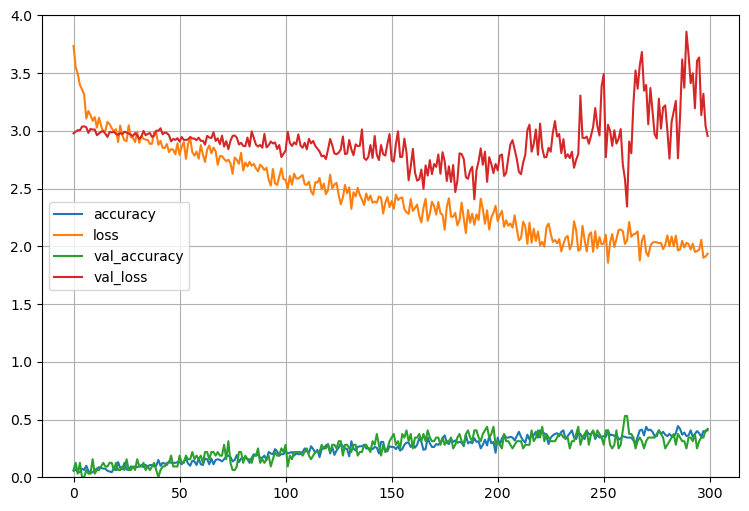

In [48]:
import os
from itertools import islice

import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


# model settings
height = 224
width = 224
dim = (height, width)
batch_size = 8
frames = 10
channels = 3
output = 20

TRAIN_PATH = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_20\train\\'
VAL_PATH = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_20\val\\'
TEST_PATH = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_20\test\\'

# transform labels from string to number
labels = labels_to_number(TRAIN_PATH)
print(f'Labels: {labels}')

# load dataset as dict
y_train_dict = videos_to_dict(TRAIN_PATH, labels)
y_val_dict = videos_to_dict(VAL_PATH, labels)
y_test_dict = videos_to_dict(TEST_PATH, labels)

print(f'\nTrain set: {len(y_train_dict)} videos - with labels')
print(f'Val   set: {len(y_val_dict)} videos - with labels')
print(f'Test  set: {len(y_test_dict)} videos - with labels')
print(f'Train set samples: {list(islice(y_train_dict.items(), 3))}')
print(f'Val   set samples: {list(islice(y_val_dict.items(), 3))}')
print(f'Test  set samples: {list(islice(y_test_dict.items(), 3))}')

# get video paths (without labels)
X_train = list(y_train_dict.keys())
X_val = list(y_val_dict.keys())
X_test = list(y_test_dict.keys())

print(f'\nTrain set: {len(X_train)} videos')
print(f'Val   set: {len(X_val)} videos')
print(f'Test  set: {len(X_test)} videos')
print(f'Train set samples: {X_train[:4]}')
print(f'Val   set samples: {X_val[:4]}')
print(f'Test  set samples: {X_test[:4]}')

# instantiation of generators for train and val sets
print('\nTrain generator')
train_generator = VideoFrameGenerator(
    list_IDs=X_train,
    labels=y_train_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=3,
    n_sequence=frames,
    shuffle=True,
    type_gen='train'
)

print('\nVal generator')
val_generator = VideoFrameGenerator(
    list_IDs=X_val,
    labels=y_val_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=3,
    n_sequence=frames,
    shuffle=True,
    type_gen='val'
)

# model building
print('\nModel building and compiling . . .')
model = create_model_wlasl20c(frames, width, height, channels, output)
model.summary()
# model compiling
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
            amsgrad=False, name="Adam")
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# callbacks creation
if not os.path.isdir('./saved_models/'):
    os.mkdir('./saved_models/')

# save the best model each time
path = './saved_models/'
checkpoint_cb = ModelCheckpoint(path + 'best_model.keras', save_best_only=True)

# start training
print('\nStart training . . .')
learn_epochs = 300
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=learn_epochs,
                    callbacks=[checkpoint_cb])

# save learning curves
if not os.path.isdir('./plots/'):
    os.mkdir('./plots/')

print('\nSaving learning curves graph . . .')
pd.DataFrame(history.history).plot(figsize=(9, 6))
plt.grid(True)
plt.gca().set_ylim(0, 4)
plt.savefig('./plots/learning_curves.png')


In [5]:
from tensorflow.keras.models import load_model

# model settings
height = 224
width = 224
dim = (height, width)
batch_size = 8
frames = 10
channels = 3
output = 20

TEST_PATH = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_20\test\\'
# transform labels from string to number
labels = labels_to_number(TEST_PATH)
# load dataset as dict
y_test_dict = videos_to_dict(TEST_PATH, labels)
# get video paths (without labels)
X_test = list(y_test_dict.keys())

# load the best model after training
last = load_model(r'C:\Users\anany\Downloads\saved_models\best_model.keras')

# instantiation of the model with best model's weights
model = create_model_wlasl20c(frames, width, height, channels, output)
model.compile(optimizer=last.optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.set_weights(last.get_weights())

# instantiation of test generator
print('\nTest generator')
test_generator = VideoFrameGenerator(
    list_IDs=X_test,
    labels=y_test_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=channels,
    n_sequence=frames,
    shuffle=False,
    type_gen='test'
)

# evaluate the best model on test set
print('\nEvaluating the best model on test set . . .')
eval_loss, eval_acc = model.evaluate(test_generator)

print(f'\nFinal Test Accuracy: {eval_acc * 100:.2f}%')

C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Test generator
Videos: 26, batches per epoch: 3

Evaluating the best model on test set . . .


C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3646 - loss: 2.3923

Final Test Accuracy: 41.67%


In [15]:
import threading

import cv2
import numpy as np
from tensorflow.keras.models import load_model

# global variables
gloss_show = 'Word: none'
labels = {
    0: 'book',
    1: 'chair',
    2: 'clothes',
    3: 'computer',
    4: 'drink',
    5: 'drum',
    6: 'family',
    7: 'football',
    8: 'go',
    9: 'hat',
    10: 'hello',
    11: 'kiss',
    12: 'like',
    13: 'play',
    14: 'school',
    15: 'street',
    16: 'table',
    17: 'university',
    18: 'violin',
    19: 'wall'
}


def main():
    # settings
    dim = (224, 224)
    frames = 10
    channels = 3
    model_path = r'C:\Users\anany\Downloads\saved_models\best_model.keras'
    threshold = .50

    print("ASL Real-time Recognition\n")
    print("[INFO] initializing ...")
    # define empty buffer
    frame_buffer = np.empty((0, *dim, channels))

    print("[INFO] loading ASL detection model ...")
    # load model
    model = load_model(model_path)

    print("[INFO] starting video stream ...")
    # start the video stream
    cap = cv2.VideoCapture(1)
    cap.set(cv2.CAP_PROP_FPS, 25)  # set the FPS to 25

    x = threading.Thread()
    # loop over the frames
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            # process the frame
            frame_res = cv2.resize(frame, dim)
            frame_res = frame_res / 255.0
            # append the frame to buffer
            frame_resh = np.reshape(frame_res, (1, *frame_res.shape))
            frame_buffer = np.append(frame_buffer, frame_resh, axis=0)
            # start sign recognition only if the buffer is full
            if frame_buffer.shape[0] == frames:
                # make the prediction
                if not x.is_alive():
                    x = threading.Thread(target=make_prediction, args=(
                        frame_buffer, model, threshold))
                    x.start()
                else:
                    pass
                # left-shift of the buffer
                frame_buffer = frame_buffer[1:frames]
                # show label
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(frame, gloss_show, (20, 450), font, 1, (0, 255, 0),
                            2, cv2.LINE_AA)
                cv2.imshow('frame', frame)

            # press Q to exit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()


def make_prediction(frame_buffer, model, threshold):
    global gloss_show

    frame_buffer_resh = frame_buffer.reshape(1, *frame_buffer.shape)
    # model prediction
    predictions = model.predict(frame_buffer_resh)[0]
    # get the best prediction
    best_pred_idx = np.argmax(predictions)
    acc_best_pred = predictions[best_pred_idx]
    # check mislabeling
    if acc_best_pred > threshold:
        gloss = labels[best_pred_idx]
        gloss_show = "Word: {: <3}  {:.2f}% ".format(
            gloss,
            acc_best_pred * 100)
        print(gloss_show)
    else:
        gloss_show = 'Word: none'


if __name__ == '__main__':
    main()

ASL Real-time Recognition

[INFO] initializing ...
[INFO] loading ASL detection model ...
[INFO] starting video stream ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Word: like  62.07% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Word: like  59.57% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Word: like  65.44% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Word: like  67.62% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Word: like  67.32% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Word: like  68.63% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Word: like  65.27% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Word: like  63.40% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Word: like  58.19% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Word: like  60.85% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Word: like  58.10% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Word: like  65.14% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Word: like  67.54% 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Word: like  68.38% 
1/1 ━━━━━━━━━

In [14]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os

# Global variable for displaying the predicted word
gloss_show = 'Word: none'

# ASL labels for prediction (you should have the same as in your trained model)
labels = {
    0: 'book',
    1: 'chair',
    2: 'clothes',
    3: 'computer',
    4: 'drink',
    5: 'drum',
    6: 'family',
    7: 'football',
    8: 'go',
    9: 'hat',
    10: 'hello',
    11: 'kiss',
    12: 'like',
    13: 'play',
    14: 'school',
    15: 'street',
    16: 'table',
    17: 'university',
    18: 'violin',
    19: 'wall'
}

def predict_sign_from_video(video_path, model, frames=10, threshold=0.5):
    # Settings
    dim = (224, 224)  # Frame size
    channels = 3      # Number of channels (RGB)
    frame_buffer = np.empty((0, *dim, channels))  # Empty frame buffer for collecting frames

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if there are no more frames in the video

        # Resize the frame to match model input
        frame_res = cv2.resize(frame, dim)
        frame_res = frame_res / 255.0  # Normalize to [0, 1]

        # Append frame to the buffer
        frame_resh = np.reshape(frame_res, (1, *frame_res.shape))
        frame_buffer = np.append(frame_buffer, frame_resh, axis=0)

        # Start prediction once the buffer is full
        if frame_buffer.shape[0] == frames:
            make_prediction(frame_buffer, model, threshold)

            # Left shift the buffer (remove the oldest frame)
            frame_buffer = frame_buffer[1:frames]

        # Display the prediction on the frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, gloss_show, (20, 450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('Video Prediction', frame)

        # Press 'q' to exit the video display
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

def make_prediction(frame_buffer, model, threshold):
    global gloss_show

    # Reshape the frame buffer and make predictions
    frame_buffer_resh = frame_buffer.reshape(1, *frame_buffer.shape)
    predictions = model.predict(frame_buffer_resh)[0]

    # Get the index of the highest prediction
    best_pred_idx = np.argmax(predictions)
    acc_best_pred = predictions[best_pred_idx]

    # If confidence is above threshold, display the predicted word
    if acc_best_pred > threshold:
        gloss = labels[best_pred_idx]
        gloss_show = "Word: {: <3}  {:.2f}%".format(gloss, acc_best_pred * 100)
        print(gloss_show)  # Print the prediction to the console
    else:
        gloss_show = 'Word: none'

if __name__ == '__main__':
    model_path = r'C:\Users\anany\Downloads\saved_models\best_model.keras'  # Path to your trained model
    video_path = r"C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_20\val\chair\09851.mp4"  # Path to the video file you want to analyze

    # Load the trained model
    print("[INFO] Loading model...")
    model = load_model(model_path)

    # Predict the sign from the provided video
    print("[INFO] Starting video prediction...")
    predict_sign_from_video(video_path, model)


[INFO] Loading model...
[INFO] Starting video prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━

In [16]:
#Text to Sign - Playing Videos
import os
import cv2
import random

# Path to the root folder where test/train/val folders are located
root_folder = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_20'  # Replace with the actual path to your dataset

import os
import random

def get_random_video_from_word(word, root_folder):
    """
    Function to get a random video from the word_label folder.
    
    :param word: The class or label (like 'dog' or 'cat')
    :param root_folder: The root folder where 'test', 'train', and 'val' are stored
    :return: A random video path from the specified word label folder
    """
    # Define the path to the test folder (or train/val as needed)
    test_folder = os.path.join(root_folder, 'train', word)
    
    # Check if the folder exists
    if not os.path.exists(test_folder):
        raise FileNotFoundError(f"The folder for word '{word}' does not exist in {test_folder}")
    
    # Get a list of all video files in the folder
    video_files = [f for f in os.listdir(test_folder) if f.endswith('.mp4')]
    
    # Check if there are any videos in the folder
    if not video_files:
        raise FileNotFoundError(f"No video files found in the folder: {test_folder}")
    
    # Randomly select a video from the list
    selected_video = random.choice(video_files)
    
    # Return the full path of the selected video
    return os.path.join(test_folder, selected_video)


def play_videos(video_paths):
    """
    Play a list of videos sequentially.
    """
    for video_path in video_paths:
        if not video_path:
            continue
        print(f"Playing video: {video_path}")

        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
            continue

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  # End of video

            # Display the frame
            cv2.imshow('Video Player', frame)

            # Wait for 'q' key press to exit the video early
            if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
                break

        cap.release()

    cv2.destroyAllWindows()

def process_input_sentence(sentence):
    """
    Process input sentence and return associated video paths.
    """
    words = sentence.split()
    video_paths = []

    for word in words:
        video_path = get_random_video_from_word(word, root_folder)
        if video_path:
            video_paths.append(video_path)
    
    return video_paths

if __name__ == '__main__':
    # Input sentence
    sentence = input("Enter a sentence: ")

    # Process the sentence to get associated video paths
    video_paths = process_input_sentence(sentence)

    # Play the videos sequentially
    if video_paths:
        play_videos(video_paths)
    else:
        print("No videos found for the given sentence.")


Playing video: C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_20\train\book\07074.mp4
Playing video: C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_20\train\computer\12327.mp4


In [ ]:
import os
from itertools import islice

import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


# model settings
height = 224
width = 224
dim = (height, width)
batch_size = 8
frames = 10
channels = 3
output = 2000

TRAIN_PATH = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_2000\train\\'
VAL_PATH = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_2000\val\\'
TEST_PATH = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_2000\test\\'

# transform labels from string to number
labels = labels_to_number(TRAIN_PATH)
print(f'Labels: {labels}')

# load dataset as dict
y_train_dict = videos_to_dict(TRAIN_PATH, labels)
y_val_dict = videos_to_dict(VAL_PATH, labels)
y_test_dict = videos_to_dict(TEST_PATH, labels)

print(f'\nTrain set: {len(y_train_dict)} videos - with labels')
print(f'Val   set: {len(y_val_dict)} videos - with labels')
print(f'Test  set: {len(y_test_dict)} videos - with labels')
print(f'Train set samples: {list(islice(y_train_dict.items(), 3))}')
print(f'Val   set samples: {list(islice(y_val_dict.items(), 3))}')
print(f'Test  set samples: {list(islice(y_test_dict.items(), 3))}')

# get video paths (without labels)
X_train = list(y_train_dict.keys())
X_val = list(y_val_dict.keys())
X_test = list(y_test_dict.keys())

print(f'\nTrain set: {len(X_train)} videos')
print(f'Val   set: {len(X_val)} videos')
print(f'Test  set: {len(X_test)} videos')
print(f'Train set samples: {X_train[:4]}')
print(f'Val   set samples: {X_val[:4]}')
print(f'Test  set samples: {X_test[:4]}')

# instantiation of generators for train and val sets
print('\nTrain generator')
train_generator = VideoFrameGenerator(
    list_IDs=X_train,
    labels=y_train_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=3,
    n_sequence=frames,
    shuffle=True,
    type_gen='train'
)

print('\nVal generator')
val_generator = VideoFrameGenerator(
    list_IDs=X_val,
    labels=y_val_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=3,
    n_sequence=frames,
    shuffle=True,
    type_gen='val'
)

# model building
print('\nModel building and compiling . . .')
model = create_model_wlasl2000(frames, width, height, channels, output)
model.summary()
# model compiling
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
            amsgrad=False, name="Adam")
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# callbacks creation
if not os.path.isdir('./saved_models/'):
    os.mkdir('./saved_models/')

# save the best model each time
path = './saved_models/'
checkpoint_cb = ModelCheckpoint(path + 'best_model_2000.keras', save_best_only=True)

# start training
print('\nStart training . . .')
learn_epochs = 10
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=learn_epochs,
                    callbacks=[checkpoint_cb])

# save learning curves
if not os.path.isdir('./plots/'):
    os.mkdir('./plots/')

print('\nSaving learning curves graph . . .')
pd.DataFrame(history.history).plot(figsize=(9, 6))
plt.grid(True)
plt.gca().set_ylim(0, 4)
plt.savefig('./plots/learning_curves.png')

In [ ]:
from tensorflow.keras.models import load_model

# model settings
height = 224
width = 224
dim = (height, width)
batch_size = 8
frames = 10
channels = 3
output = 2000

TEST_PATH = r'C:\Users\anany\Downloads\WLASL-dataset-sample\WLASL_2000\test\\'
# transform labels from string to number
labels = labels_to_number(TEST_PATH)
# load dataset as dict
y_test_dict = videos_to_dict(TEST_PATH, labels)
# get video paths (without labels)
X_test = list(y_test_dict.keys())

# load the best model after training
last = load_model(r'C:\Users\anany\Downloads\saved_models\best_model_2000.keras')

# instantiation of the model with best model's weights
model = create_model_wlasl20c(frames, width, height, channels, output)
model.compile(optimizer=last.optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.set_weights(last.get_weights())

# instantiation of test generator
print('\nTest generator')
test_generator = VideoFrameGenerator(
    list_IDs=X_test,
    labels=y_test_dict,
    batch_size=batch_size,
    dim=dim,
    n_channels=channels,
    n_sequence=frames,
    shuffle=False,
    type_gen='test'
)

# evaluate the best model on test set
print('\nEvaluating the best model on test set . . .')
eval_loss, eval_acc = model.evaluate(test_generator)

print(f'\nFinal Test Accuracy: {eval_acc * 100:.2f}%')